<a href="https://colab.research.google.com/github/lMonolitol/Capstone/blob/main/ClasificaciondeBullying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🤖 MULTI-MODEL BULLYING DETECTION SYSTEM
Developed with CNN, DenseNet and YOLO

📋 MAIN MENU:
1. 🏋️ Train models
2. 📊 Evaluate models
3. 🖼️ Analyze single image
4. 🌐 Analyze image from URL
5. 📁 Batch folder analysis
6. ❌ Exit

🔢 Select an option (1-6): 5
📁 BATCH FOLDER ANALYSIS


🔧 Installing dependencies...
✅ Dependencies installed
✅ YOLO configured successfully
Found 100 images belonging to 2 classes.
🔍 Class mapping: {'bullying': 0, 'no_bullying': 1}
📂 Folder path: /content/drive/MyDrive/bullying_dataset/test
📷 Found 6 images to analyze

🔄 Processing images...
📸 Analyzing 1/6: test1.jpg
📸 Analyzing 2/6: test2.jpg
📸 Analyzing 3/6: test3.jpg
📸 Analyzing 4/6: test4.jpg
📸 Analyzing 5/6: test5.jpg
📸 Analyzing 6/6: test6.jpg

📊 BATCH REPORT COMPLETED
🖼️ Total images: 6
🔴 Bullying detected: 2
🟢 No bullying: 4
📈 Bullying percentage: 33.3%

⚠️ DETECTED BULLYING CASES:
----------------------------------------
📁 test3.jpg
   Confidence: 53.4%
   Ensemble Score: 0.534
   Detected persons: 6

📁 test5.jpg
   Confidence: 50.5%
   Ensemble Score: 0.505
   Detected persons: 4



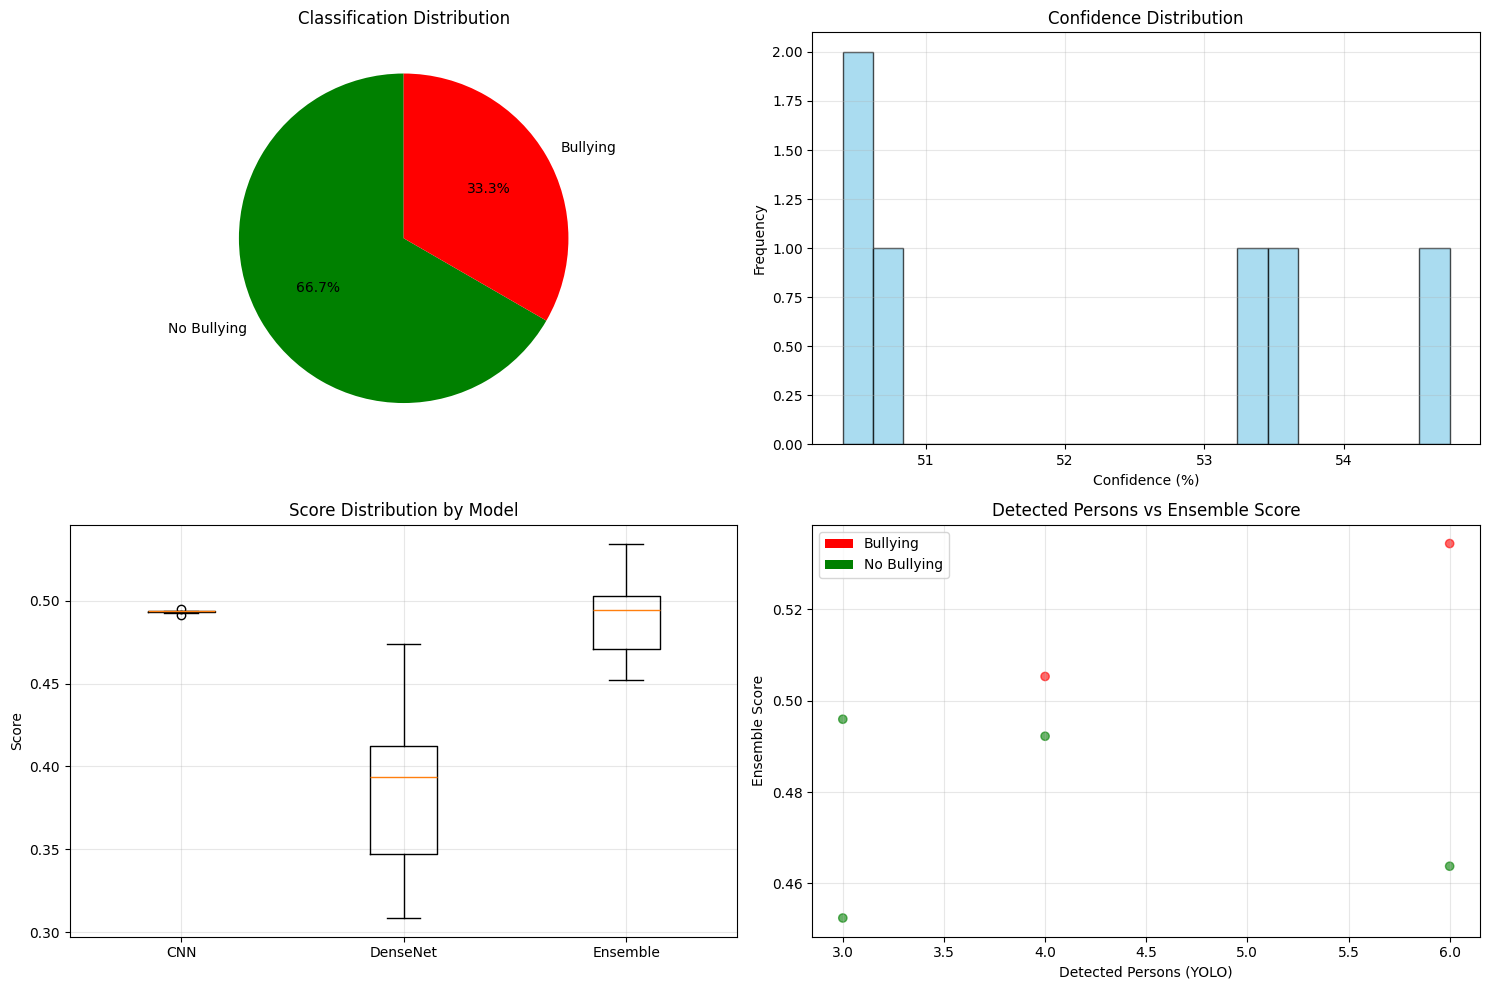


📋 MAIN MENU:
1. 🏋️ Train models
2. 📊 Evaluate models
3. 🖼️ Analyze single image
4. 🌐 Analyze image from URL
5. 📁 Batch folder analysis
6. ❌ Exit


👋 Program interrupted. See you later!


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing import image
import glob
import cv2
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Path configuration
base_path = '/content/drive/MyDrive/bullying_dataset'
train_path = os.path.join(base_path, 'train')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

# Model paths
cnn_model_path = os.path.join(base_path, 'bullying_cnn_model.h5')
densenet_model_path = os.path.join(base_path, 'bullying_densenet_model.h5')
ensemble_model_path = os.path.join(base_path, 'bullying_ensemble_model.h5')

# Global configuration
IMG_SIZE = 224  # Changed to 224 for DenseNet
BATCH_SIZE = 8

def install_dependencies():
    """Install necessary dependencies for YOLO"""
    print("🔧 Installing dependencies...")
    os.system('pip install ultralytics')
    print("✅ Dependencies installed")

def create_cnn_model():
    """Create custom CNN model"""
    model = tf.keras.models.Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_densenet_model():
    """Create DenseNet model with transfer learning"""
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the first layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def setup_yolo():
    """Set up YOLO for person detection"""
    try:
        from ultralytics import YOLO
        # Download pre-trained YOLOv8 model
        model = YOLO('yolov8n.pt')  # nano version for speed
        print("✅ YOLO configured successfully")
        return model
    except Exception as e:
        print(f"❌ Error setting up YOLO: {e}")
        return None

def detect_people_yolo(image_path, yolo_model):
    """Detect people in the image using YOLO"""
    if yolo_model is None:
        return []

    try:
        results = yolo_model(image_path, verbose=False)
        people_detections = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    if int(box.cls) == 0:  # Class 0 = person in COCO dataset
                        confidence = float(box.conf)
                        if confidence > 0.5:  # Only high confidence detections
                            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                            people_detections.append({
                                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                                'confidence': confidence
                            })

        return people_detections
    except Exception as e:
        print(f"Error in YOLO detection: {e}")
        return []

def get_class_mapping():
    """Get class mapping"""
    if os.path.exists(train_path):
        temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
            train_path, target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=1, class_mode='binary', shuffle=False
        )
        class_indices = temp_gen.class_indices
        print(f"🔍 Class mapping: {class_indices}")
        return class_indices
    else:
        print("⚠️ Could not get class mapping, using default")
        return {'bullying': 1, 'no_bullying': 0}

def analyze_dataset_balance():
    """Analyze dataset balance"""
    print("⚖️ DATASET BALANCE ANALYSIS:")
    print("=" * 50)

    for folder_name in ['train', 'validation']:
        folder_path = os.path.join(base_path, folder_name)
        if os.path.exists(folder_path):
            bullying_path = os.path.join(folder_path, 'bullying')
            no_bullying_path = os.path.join(folder_path, 'no_bullying')

            if os.path.exists(bullying_path) and os.path.exists(no_bullying_path):
                bullying_count = len([f for f in os.listdir(bullying_path)
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                no_bullying_count = len([f for f in os.listdir(no_bullying_path)
                                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

                total = bullying_count + no_bullying_count
                if total > 0:
                    bullying_pct = (bullying_count / total) * 100
                    no_bullying_pct = (no_bullying_count / total) * 100

                    print(f"\n📁 {folder_name.upper()}:")
                    print(f"  🔴 Bullying: {bullying_count} ({bullying_pct:.1f}%)")
                    print(f"  🟢 No Bullying: {no_bullying_count} ({no_bullying_pct:.1f}%)")

                    if abs(bullying_pct - 50) > 30:
                        print(f"  ⚠️ HIGHLY IMBALANCED DATASET!")

def train_models():
    """Train CNN and DenseNet models"""
    print("🤖 MULTI-MODEL TRAINING")
    print("=" * 50)

    if not os.path.exists(train_path) or not os.path.exists(validation_path):
        print("❌ Required folders not found.")
        return

    analyze_dataset_balance()

    # Prepare data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    print(f"📊 Classes found: {train_generator.class_indices}")
    print(f"📚 Training images: {train_generator.samples}")
    print(f"🔍 Validation images: {validation_generator.samples}")

    steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
    validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

    # Callbacks
    callbacks_cnn = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(cnn_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    callbacks_densenet = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(densenet_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    # Train CNN
    print("\n🧠 TRAINING CNN MODEL...")
    cnn_model = create_cnn_model()
    print("CNN Architecture:")
    cnn_model.summary()

    history_cnn = cnn_model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_cnn,
        verbose=1
    )

    # Train DenseNet
    print("\n🌐 TRAINING DENSENET MODEL...")
    densenet_model = create_densenet_model()
    print("DenseNet Architecture:")
    densenet_model.summary()

    history_densenet = densenet_model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=20,  # Fewer epochs due to transfer learning
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_densenet,
        verbose=1
    )

    # Visualize results
    plot_training_history(history_cnn, history_densenet)

    print(f"✅ Models saved:")
    print(f"  📁 CNN: {cnn_model_path}")
    print(f"  📁 DenseNet: {densenet_model_path}")

def plot_training_history(history_cnn, history_densenet):
    """Visualize training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # CNN Loss
    axes[0, 0].plot(history_cnn.history['loss'], label='CNN Train Loss')
    axes[0, 0].plot(history_cnn.history['val_loss'], label='CNN Val Loss')
    axes[0, 0].set_title('CNN - Loss During Training')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # CNN Accuracy
    axes[0, 1].plot(history_cnn.history['accuracy'], label='CNN Train Acc')
    axes[0, 1].plot(history_cnn.history['val_accuracy'], label='CNN Val Acc')
    axes[0, 1].set_title('CNN - Accuracy During Training')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # DenseNet Loss
    axes[1, 0].plot(history_densenet.history['loss'], label='DenseNet Train Loss')
    axes[1, 0].plot(history_densenet.history['val_loss'], label='DenseNet Val Loss')
    axes[1, 0].set_title('DenseNet - Loss During Training')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # DenseNet Accuracy
    axes[1, 1].plot(history_densenet.history['accuracy'], label='DenseNet Train Acc')
    axes[1, 1].plot(history_densenet.history['val_accuracy'], label='DenseNet Val Acc')
    axes[1, 1].set_title('DenseNet - Accuracy During Training')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def create_ensemble_prediction(cnn_pred, densenet_pred, yolo_persons, weights=[0.4, 0.5, 0.1]):
    """Create ensemble prediction combining the three models"""
    # Normalize predictions
    cnn_score = cnn_pred[0] if isinstance(cnn_pred, np.ndarray) else cnn_pred
    densenet_score = densenet_pred[0] if isinstance(densenet_pred, np.ndarray) else densenet_pred

    # YOLO factor: more detected people = higher probability of interaction/bullying
    yolo_factor = min(len(yolo_persons) / 3.0, 1.0)  # Normalize between 0-1

    # Combine predictions with weights
    ensemble_score = (weights[0] * cnn_score +
                     weights[1] * densenet_score +
                     weights[2] * yolo_factor)

    return ensemble_score

def predict_multi_model(img_path, models, yolo_model, class_indices):
    """Prediction using multiple models"""
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Individual predictions
        cnn_pred = models['cnn'].predict(img_array, verbose=0)[0][0] if models['cnn'] else 0.5
        densenet_pred = models['densenet'].predict(img_array, verbose=0)[0][0] if models['densenet'] else 0.5

        # YOLO detection
        yolo_persons = detect_people_yolo(img_path, yolo_model)

        # Ensemble prediction
        ensemble_score = create_ensemble_prediction(cnn_pred, densenet_pred, yolo_persons)

        # Determine final classification
        is_bullying = ensemble_score > 0.5
        confidence = ensemble_score * 100 if is_bullying else (1 - ensemble_score) * 100

        return {
            'is_bullying': is_bullying,
            'confidence': confidence,
            'ensemble_score': ensemble_score,
            'cnn_score': cnn_pred,
            'densenet_score': densenet_pred,
            'yolo_persons': len(yolo_persons),
            'yolo_detections': yolo_persons,
            'img': img
        }

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

def evaluate_models():
    """Evaluate all models"""
    print("📊 MULTI-MODEL EVALUATION")
    print("=" * 50)

    # Load models
    models = {}
    if os.path.exists(cnn_model_path):
        models['cnn'] = load_model(cnn_model_path)
        print("✅ CNN loaded")
    else:
        models['cnn'] = None
        print("❌ CNN not found")

    if os.path.exists(densenet_model_path):
        models['densenet'] = load_model(densenet_model_path)
        print("✅ DenseNet loaded")
    else:
        models['densenet'] = None
        print("❌ DenseNet not found")

    # Set up YOLO
    install_dependencies()
    yolo_model = setup_yolo()

    if not any(models.values()):
        print("❌ No trained models found")
        return

    if not os.path.exists(validation_path):
        print("❌ Validation folder not found")
        return

    class_indices = get_class_mapping()

    # Evaluate on validation set
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    print(f"📂 Evaluating {validation_generator.samples} images")

    predictions = {'cnn': [], 'densenet': [], 'ensemble': []}
    true_labels = validation_generator.classes

    for i in range(min(validation_generator.samples, 100)):  # Limit for demo
        img_path = os.path.join(validation_path, validation_generator.filenames[i])

        result = predict_multi_model(img_path, models, yolo_model, class_indices)
        if result:
            predictions['cnn'].append(1 if result['cnn_score'] > 0.5 else 0)
            predictions['densenet'].append(1 if result['densenet_score'] > 0.5 else 0)
            predictions['ensemble'].append(1 if result['is_bullying'] else 0)

    # Show comparative metrics
    show_comparative_metrics(true_labels[:len(predictions['ensemble'])], predictions)

def show_comparative_metrics(true_labels, predictions):
    """Show comparative metrics of the models"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    models_names = ['CNN', 'DenseNet', 'Ensemble']
    colors = ['blue', 'green', 'red']

    for i, (model_name, color) in enumerate(zip(models_names, colors)):
        model_key = model_name.lower()
        if model_key in predictions:
            cm = confusion_matrix(true_labels, predictions[model_key])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       xticklabels=['No Bullying', 'Bullying'],
                       yticklabels=['No Bullying', 'Bullying'])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Prediction')
            axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # Calculate and show metrics
    print("\n🎯 COMPARATIVE METRICS:")
    print("=" * 60)
    print(f"{'Model':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10}")
    print("-" * 60)

    for model_name in models_names:
        model_key = model_name.lower()
        if model_key in predictions:
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            acc = accuracy_score(true_labels, predictions[model_key])
            prec = precision_score(true_labels, predictions[model_key], zero_division=0)
            rec = recall_score(true_labels, predictions[model_key], zero_division=0)
            f1 = f1_score(true_labels, predictions[model_key], zero_division=0)

            print(f"{model_name:<12} {prec:<10.3f} {rec:<10.3f} {f1:<10.3f} {acc:<10.3f}")

def analyze_single_image():
    """Single image analysis with all models"""
    print("🖼️ MULTI-MODEL SINGLE IMAGE ANALYSIS")
    print("=" * 50)

    # Load models
    models = {}
    if os.path.exists(cnn_model_path):
        models['cnn'] = load_model(cnn_model_path)
    else:
        models['cnn'] = None
        print("⚠️ CNN not available")

    if os.path.exists(densenet_model_path):
        models['densenet'] = load_model(densenet_model_path)
    else:
        models['densenet'] = None
        print("⚠️ DenseNet not available")

    if not any(models.values()):
        print("❌ No models available")
        return

    # Set up YOLO
    install_dependencies()
    yolo_model = setup_yolo()

    class_indices = get_class_mapping()

    img_path = input("📷 Image path: ")

    if not os.path.exists(img_path):
        print("❌ Image not found")
        return

    # Perform prediction
    result = predict_multi_model(img_path, models, yolo_model, class_indices)

    if not result:
        print("❌ Error in analysis")
        return

    # Show results
    filename = os.path.basename(img_path)

    if result['is_bullying']:
        result_text = "🔴 BULLYING DETECTED"
        color = "red"
        recommendation = "⚠️ Review recommended"
    else:
        result_text = "🟢 NO BULLYING DETECTED"
        color = "green"
        recommendation = "✅ Safe image"

    print(f"\n{result_text}")
    print("=" * 50)
    print(f"📊 Final Confidence: {result['confidence']:.1f}%")
    print(f"🤖 CNN Score: {result['cnn_score']:.3f}")
    print(f"🌐 DenseNet Score: {result['densenet_score']:.3f}")
    print(f"👥 People detected (YOLO): {result['yolo_persons']}")
    print(f"📈 Ensemble Score: {result['ensemble_score']:.3f}")
    print(f"💡 {recommendation}")

    # Visualize results
    visualize_multi_model_results(result, filename, img_path)

def visualize_multi_model_results(result, filename, img_path):
    """Visualize multi-model analysis results"""
    fig = plt.figure(figsize=(20, 12))

    # Original image with YOLO detections
    ax1 = plt.subplot(2, 3, 1)
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # Draw YOLO bounding boxes
    for detection in result['yolo_detections']:
        x1, y1, x2, y2 = detection['bbox']
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_cv, f"Person {detection['confidence']:.2f}",
                   (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(img_cv)
    plt.title(f'Original Image\n{result["yolo_persons"]} person(s) detected')
    plt.axis('off')

    # Bar chart with individual scores
    ax2 = plt.subplot(2, 3, 2)
    models_names = ['CNN', 'DenseNet', 'Ensemble']
    scores = [result['cnn_score'], result['densenet_score'], result['ensemble_score']]
    colors = ['blue', 'green', 'red']

    bars = plt.bar(models_names, scores, color=colors, alpha=0.7)
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Threshold (0.5)')
    plt.ylabel('Score')
    plt.title('Scores by Model')
    plt.ylim(0, 1)

    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.legend()
    plt.grid(True, alpha=0.3)

    # Pie chart of final confidence
    ax3 = plt.subplot(2, 3, 3)
    if result['is_bullying']:
        sizes = [result['confidence'], 100 - result['confidence']]
        labels = [f'Bullying\n{result["confidence"]:.1f}%', f'No Bullying\n{100-result["confidence"]:.1f}%']
        colors_pie = ['red', 'lightcoral']
    else:
        sizes = [result['confidence'], 100 - result['confidence']]
        labels = [f'No Bullying\n{result["confidence"]:.1f}%', f'Bullying\n{100-result["confidence"]:.1f}%']
        colors_pie = ['green', 'lightgreen']

    plt.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    plt.title('Final Ensemble Confidence')

    # Contribution of each model to ensemble
    ax4 = plt.subplot(2, 3, 4)
    weights = [0.4, 0.5, 0.1]  # CNN, DenseNet, YOLO
    contributions = [
        weights[0] * result['cnn_score'],
        weights[1] * result['densenet_score'],
        weights[2] * min(result['yolo_persons'] / 3.0, 1.0)
    ]

    plt.bar(['CNN', 'DenseNet', 'YOLO'], weights,
           color=['lightblue', 'lightgreen', 'lightyellow'], alpha=0.7, label='Weight')
    plt.bar(['CNN', 'DenseNet', 'YOLO'], contributions,
           color=['blue', 'green', 'yellow'], alpha=0.9, label='Contribution')

    plt.ylabel('Value')
    plt.title('Contribution to Ensemble')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confidence histogram
    ax5 = plt.subplot(2, 3, 5)
    confidence_ranges = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    current_range = int(result['confidence'] // 20)
    if current_range >= 5:
        current_range = 4

    heights = [0] * 5
    heights[current_range] = 1

    bars_conf = plt.bar(confidence_ranges, heights, color=['red' if result['is_bullying'] else 'green'])
    plt.ylabel('Current Classification')
    plt.title('Confidence Range')
    plt.ylim(0, 1.2)

    # Descriptive text with analysis
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    analysis_text = f"""
DETAILED ANALYSIS
{'='*20}

📁 File: {filename}
{'='*30}

🎯 FINAL RESULT:
{('🔴 BULLYING DETECTED' if result['is_bullying'] else '🟢 NO BULLYING')}

📊 METRICS:
• Confidence: {result['confidence']:.1f}%
• Ensemble Score: {result['ensemble_score']:.3f}

🤖 INDIVIDUAL MODELS:
• CNN: {result['cnn_score']:.3f}
• DenseNet: {result['densenet_score']:.3f}

👥 YOLO DETECTION:
• People detected: {result['yolo_persons']}
• YOLO factor: {min(result['yolo_persons'] / 3.0, 1.0):.3f}

💡 RECOMMENDATION:
{('⚠️ Requires manual review' if result['is_bullying'] else '✅ Safe image')}
"""

    plt.text(0.05, 0.95, analysis_text, transform=ax6.transAxes,
             fontfamily='monospace', fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

def predict_from_url():
    """Prediction from image URL"""
    print("🌐 PREDICTION FROM URL")
    print("=" * 30)

    # Load models
    models = {}
    if os.path.exists(cnn_model_path):
        models['cnn'] = load_model(cnn_model_path)
    else:
        models['cnn'] = None
        print("⚠️ CNN not available")

    if os.path.exists(densenet_model_path):
        models['densenet'] = load_model(densenet_model_path)
    else:
        models['densenet'] = None
        print("⚠️ DenseNet not available")

    if not any(models.values()):
        print("❌ No models available")
        return

    # Configure YOLO
    install_dependencies()
    yolo_model = setup_yolo()

    class_indices = get_class_mapping()

    url = input("🔗 Image URL: ")

    try:
        # Download image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        # Save temporarily
        temp_path = '/tmp/temp_image.jpg'
        img.save(temp_path)

        # Perform prediction
        result = predict_multi_model(temp_path, models, yolo_model, class_indices)

        if not result:
            print("❌ Error in analysis")
            return

        # Show results
        filename = "url_image"

        if result['is_bullying']:
            result_text = "🔴 BULLYING DETECTED"
            recommendation = "⚠️ Review recommended"
        else:
            result_text = "🟢 NO BULLYING DETECTED"
            recommendation = "✅ Safe image"

        print(f"\n{result_text}")
        print("=" * 50)
        print(f"📊 Final Confidence: {result['confidence']:.1f}%")
        print(f"🤖 CNN Score: {result['cnn_score']:.3f}")
        print(f"🌐 DenseNet Score: {result['densenet_score']:.3f}")
        print(f"👥 Detected persons (YOLO): {result['yolo_persons']}")
        print(f"📈 Ensemble Score: {result['ensemble_score']:.3f}")
        print(f"💡 {recommendation}")

        # Visualize results
        visualize_multi_model_results(result, filename, temp_path)

        # Clean temporary file
        os.remove(temp_path)

    except Exception as e:
        print(f"❌ Error processing URL: {e}")

def batch_analyze_folder():
    """Batch analysis of a complete folder"""
    print("📁 BATCH FOLDER ANALYSIS")
    print("=" * 30)

    # Load models
    models = {}
    if os.path.exists(cnn_model_path):
        models['cnn'] = load_model(cnn_model_path)
    else:
        models['cnn'] = None
        print("⚠️ CNN not available")

    if os.path.exists(densenet_model_path):
        models['densenet'] = load_model(densenet_model_path)
    else:
        models['densenet'] = None
        print("⚠️ DenseNet not available")

    if not any(models.values()):
        print("❌ No models available")
        return

    # Configure YOLO
    install_dependencies()
    yolo_model = setup_yolo()

    class_indices = get_class_mapping()

    folder_path = input("📂 Folder path: ")

    if not os.path.exists(folder_path):
        print("❌ Folder not found")
        return

    # Get all images
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    all_images = []

    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(folder_path, ext)))
        all_images.extend(glob.glob(os.path.join(folder_path, ext.upper())))

    if not all_images:
        print("❌ No images found in folder")
        return

    print(f"📷 Found {len(all_images)} images to analyze")

    results = []
    bullying_detected = 0

    print("\n🔄 Processing images...")
    for i, img_path in enumerate(all_images):
        print(f"📸 Analyzing {i+1}/{len(all_images)}: {os.path.basename(img_path)}")

        result = predict_multi_model(img_path, models, yolo_model, class_indices)

        if result:
            result['filename'] = os.path.basename(img_path)
            result['full_path'] = img_path
            results.append(result)

            if result['is_bullying']:
                bullying_detected += 1

    # Generate report
    print(f"\n📊 BATCH REPORT COMPLETED")
    print("=" * 50)
    print(f"🖼️ Total images: {len(results)}")
    print(f"🔴 Bullying detected: {bullying_detected}")
    print(f"🟢 No bullying: {len(results) - bullying_detected}")
    print(f"📈 Bullying percentage: {(bullying_detected/len(results)*100):.1f}%")

    # Show detected bullying cases
    if bullying_detected > 0:
        print(f"\n⚠️ DETECTED BULLYING CASES:")
        print("-" * 40)
        for result in results:
            if result['is_bullying']:
                print(f"📁 {result['filename']}")
                print(f"   Confidence: {result['confidence']:.1f}%")
                print(f"   Ensemble Score: {result['ensemble_score']:.3f}")
                print(f"   Detected persons: {result['yolo_persons']}")
                print()

    # Create report visualization
    create_batch_report_visualization(results)

def create_batch_report_visualization(results):
    """Create batch report visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Distribution of classifications
    bullying_count = sum(1 for r in results if r['is_bullying'])
    no_bullying_count = len(results) - bullying_count

    ax1 = axes[0, 0]
    labels = ['No Bullying', 'Bullying']
    sizes = [no_bullying_count, bullying_count]
    colors = ['green', 'red']

    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Classification Distribution')

    # Confidence histogram
    ax2 = axes[0, 1]
    confidences = [r['confidence'] for r in results]
    ax2.hist(confidences, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Confidence (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Confidence Distribution')
    ax2.grid(True, alpha=0.3)

    # Score comparison by model
    ax3 = axes[1, 0]
    cnn_scores = [r['cnn_score'] for r in results]
    densenet_scores = [r['densenet_score'] for r in results]
    ensemble_scores = [r['ensemble_score'] for r in results]

    ax3.boxplot([cnn_scores, densenet_scores, ensemble_scores],
               labels=['CNN', 'DenseNet', 'Ensemble'])
    ax3.set_ylabel('Score')
    ax3.set_title('Score Distribution by Model')
    ax3.grid(True, alpha=0.3)

    # Person detection vs bullying
    ax4 = axes[1, 1]
    yolo_counts = [r['yolo_persons'] for r in results]
    bullying_labels = [1 if r['is_bullying'] else 0 for r in results]

    # Scatter plot
    colors_scatter = ['red' if b else 'green' for b in bullying_labels]
    ax4.scatter(yolo_counts, ensemble_scores, c=colors_scatter, alpha=0.6)
    ax4.set_xlabel('Detected Persons (YOLO)')
    ax4.set_ylabel('Ensemble Score')
    ax4.set_title('Detected Persons vs Ensemble Score')
    ax4.grid(True, alpha=0.3)

    # Add legend for scatter plot
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', label='Bullying'),
                      Patch(facecolor='green', label='No Bullying')]
    ax4.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

def main_menu():
    """Main system menu"""
    print("🤖 MULTI-MODEL BULLYING DETECTION SYSTEM")
    print("=" * 60)
    print("Developed with CNN, DenseNet and YOLO")
    print("=" * 60)

    while True:
        print("\n📋 MAIN MENU:")
        print("1. 🏋️ Train models")
        print("2. 📊 Evaluate models")
        print("3. 🖼️ Analyze single image")
        print("4. 🌐 Analyze image from URL")
        print("5. 📁 Batch folder analysis")
        print("6. ❌ Exit")

        try:
            option = input("\n🔢 Select an option (1-6): ").strip()

            if option == '1':
                train_models()
            elif option == '2':
                evaluate_models()
            elif option == '3':
                analyze_single_image()
            elif option == '4':
                predict_from_url()
            elif option == '5':
                batch_analyze_folder()
            elif option == '6':
                print("👋 See you later!")
                break
            else:
                print("❌ Invalid option. Please select 1-6")

        except KeyboardInterrupt:
            print("\n\n👋 Program interrupted. See you later!")
            break
        except Exception as e:
            print(f"❌ Unexpected error: {e}")

# Run the main program
if __name__ == "__main__":
    main_menu()